In [29]:
from toolz.curried import *


import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

#### Synthetic Control

An advantage of panel data for causal identification is that you compare units with each other, but also with former selves, which allow you to estimate counterfactuals $Y_0$ with more plausible assumptions. Difference-in-differences(DID) relies on similar (parallel) growth trajectories between treated and control, and this allows DID to identify treatment effects even if levels of $Y_0$ between treated and control were different. DID works great if you have a relatively large number of units N compared to time periods, T, but falls short when the reverse is true.

Synthetic control was designed to work with very few, even one, treatment unit. The idea is to combine control units in order to craft a synthetic control that would approximate the behavior of treated units in the absence of treatment. By doing so, synthetic control avoids making a parallel trend assumption as the synthetic control, when well crafted, won't be just parallel, but perfectly overlapping with the counterfactual $E[Y_0|D=1]$.

#### Online Marketing

Online marketing allows for better tracking than offline marketing, but it has its own challenges for causal inference. Specifically, online marketing allows better attribution ie you know if a customer reached your product using some paid marketing link. But you cant say what would have happened to the customer had they not seen the online ad. If the customer only came because they saw the ad, then the ad is bringing in extra customers. But what if the customers would have come either way and only came through paid link because the link was on top of the page. In other words, attribution is not the same as incrementality. Since you can't randomize who gets to see your ads, then treating entire geographies and doing some sort of panel data analysis is a good idea for online marketing. So for the online marketing data, we still have the city as the unit, date as the time dimension, a treated column, which marks if the city will eventually be treated, and a post-treatment column, which marks the post-intervention period, auxilliary columns such as the population of that city (as of 2013) and state. Outcome variable is daily app downloads and treatment is having marketing campaign turned on for that city. The treatment is implemented on the treated cities at the same time, which means you have a simple block design. The catch is that you have a smaller number of treated units - only three cities. In the dataset below, one of the cities has a significantly larger population than the rest. This means it is very hard to combine the other cities to make a synthetic control. In general, entire markets will have different sizes, making comparison across them difficult. A common approach is to normalize the outcome by the market size, by dividing the app downloads by the city's population to create a normalized version of the outcome. The new outcome, represents the number of daily downloads as a percentage of the market size. An online marketing campaign was launched for those cities in 2022-05-01 and the campaign also stayed on for the remainder of the analyzed time window. To determine average treatment effect on the treated (ATT):

$ATT=E[Y|D=1,Post=1]-E[Y_0|D=1,Post=1]$

In [30]:
df = (pd.read_csv("data/online_mkt.csv").astype({"date": "datetime64[ns]"})) # assign datetime type to date col
df.head()

,app_download,population,city,state,date,post,treated
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1


In [31]:
# list of treated cities
treated = list(df.query("treated==1")["city"].unique())
treated

['sao_paulo', 'porto_alegre', 'joao_pessoa']

In [32]:
df_norm = df.assign(
    app_download_pct = 100*df["app_download"] / df["population"]
)
df_norm.head()

,app_download,population,city,state,date,post,treated,app_download_pct
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1,0.024733
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1,0.021789
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1,0.015545
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1,0.011705
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1,0.010067


In [33]:
tr_period = df_norm.query("post==1")["date"].min()  # post-intervention start date
tr_period

Timestamp('2022-05-01 00:00:00')

In [34]:
df_norm.date.nunique()  # repeated periods

122

In [35]:
df_norm.city.nunique() # total  number of cities (only 3 are treated the rest are control)

50

Text(0, 0.5, 'app_download_pct')

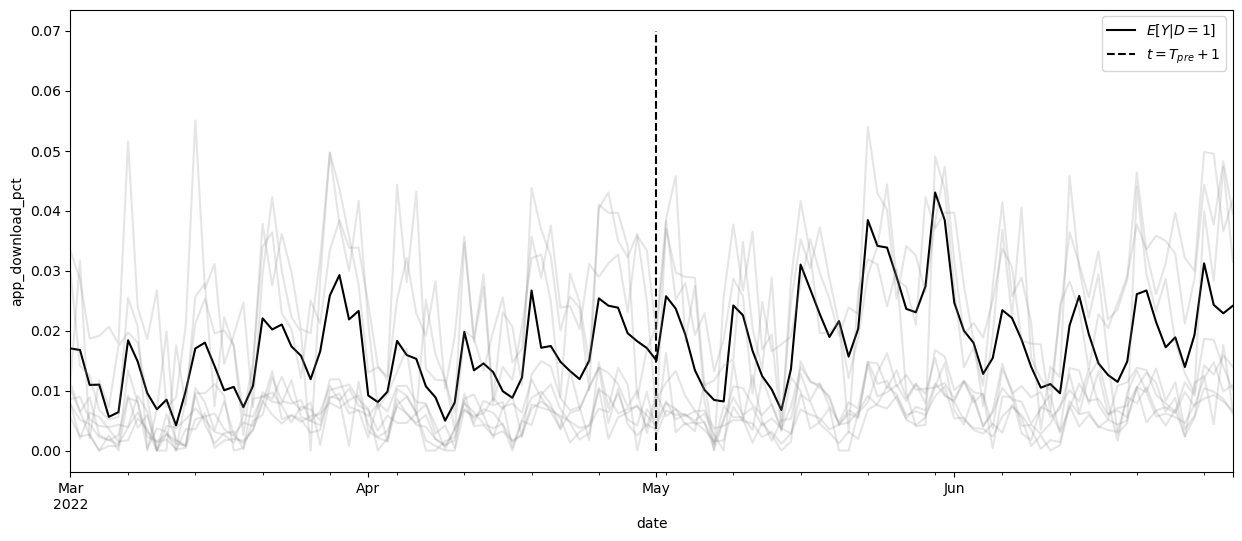

In [36]:
np.random.seed(123)

df_sc = df_norm.pivot(index="date", columns="city", values="app_download_pct")

ax = df_sc[treated].mean(axis=1  # treated = treated cities columns, average treated outcome per date
                         ).plot(figsize=(15,6), label="$E[Y|D=1]$") 
ax.vlines(tr_period, 0, 0.07, ls="dashed", label="$t=T_{pre}+1$")   # beginning of post-treatment period
ax.legend()
df_sc.drop(columns=treated).sample(frac=0.2, # sample 20% of control cities, plot outcome evolution over time
                                   axis=1).plot(color="0.5", alpha=0.2, legend=False, ax=ax)
plt.ylabel("app_download_pct")

#### Matrix Representation

Panel data can be represented as a matrix, where one dimension is the time period and the other dimension denotes the units. Synthetic control makes explicit use of that matrix. Say the rows of the matrix are the time periods and the columns of the matrix are the units (cities). The top left corresponds to control units prior to the treatment period; the top right corresponds to treated units prior to treatment period; bottom left contains control units after treatment period; bottom right is treated unit after treatment period. The treatment indicator $w_{ti}$ is zero everywhere except for the block with treated units after the treated period (bottom right). 

$W=\begin{bmatrix}0_{pre,co} && 0_{pre,tr} \\ 0_{post,co} && 1_{post,tr}  \end{bmatrix}$ - treatement assigmnent

$Y=\begin{bmatrix}Y(0)_{pre,co} && Y(0)_{pre,tr} \\ Y(0)_{post,co} && Y(1)_{post,tr}  \end{bmatrix}$ - potential outcomes

$ATT= Y(1)_{post,tr} - Y(0)_{post,tr}$

Note that in the matrix, the post-treatment period is on the bottom and the treated units are to the right.Estimating the ATT involves estimating the missing potential outcome $Y(0)_{post,tr}$, which is not observed. In other words, you need to know what would have happened to the treated units at the post-treatment period had they not been treated. To do that, you ideally have to leverage all the other blocks at your disposal, $Y(0)_{pre,co}$, $Y(0)_{pre,tr}$ and $Y(0)_{post,co}$.

In [37]:
# function to represent data in matrix format
def reshape_sc_data(df: pd.DataFrame,
                    geo_col: str,                   # unit column (eg people, cities, etc)
                    time_col: str,                  # time dimension column
                    y_col: str,                     # outcome column
                    tr_geos: str,                   # treated units 
                    tr_start: str):                 # post-intervention date
    
    df_pivot = df.pivot(index=time_col, columns=geo_col, values=y_col)   

    y_co = df_pivot.drop(columns=tr_geos)           # outcome for control, drop treated units columns
    y_tr = df_pivot[tr_geos]                        # outcome for treated, select treated units columns

    y_pre_co = y_co[df_pivot.index < tr_start]      # pre-treatment control, select rows before intervention
    y_pre_tr = y_tr[df_pivot.index < tr_start]      # pre-treatment treated, select rows before intervention

    y_post_co = y_co[df_pivot.index >= tr_start]    # post-treatment control, select rows after intervention
    y_post_tr = y_tr[df_pivot.index >= tr_start]    # post-treatment treated, select rows after intervention

    return y_pre_co, y_pre_tr, y_post_co, y_post_tr     # return four block matrix

In [38]:
y_pre_co, y_pre_tr, y_post_co, y_post_tr = reshape_sc_data(df_norm,
                                                           geo_col="city",
                                                           time_col="date",
                                                           y_col="app_download_pct",
                                                           tr_geos=treated, # list of treated units
                                                           tr_start=str(tr_period))
y_pre_tr.head()

city,sao_paulo,porto_alegre,joao_pessoa
date,,,
2022-03-01,0.024733,0.004288,0.022039
2022-03-02,0.021789,0.008107,0.020344
2022-03-03,0.015545,0.004891,0.012352
2022-03-04,0.011705,0.002948,0.018285
2022-03-05,0.010067,0.006767,0.000000


#### Synthetic Control as Horizontal Regression

The main idea behind synthetic control is that using the pre-treatment period, to find a way to combine the control units (cities) to approximate the average outcome of the treated units. This can be framed as an optimiztion problem, where you'll look for unit weights $\omega_i$, such that, when you multiply each weight by its unit's outcome, $\omega_iy_i$, you get something resembling the treated unit's outcome:

$\hat \omega ^{sc} = argmin_{\omega}||\bar y_{pre,tr} - Y_{pre, co} \omega_{co}||^2$

Then to estimate $E[Y(0)|D=1,Post=1]$ and get the ATT estimate, you can use the synthetic control $Y_{post, co}\omega _{co}$.  Synthetic control is nothing more than a regression that uses the outcome of the control as features to try to predict the average outcome of the treated units. This is done using only the pre-intervention period so that the regression estimates $E[Y_0|D=1]$ (expectation or average pretreatment outcome for all D=1 ie treated group). We can use OLS to build a synthetic control, using pre-treatment outcome of the control units as if it was the covariate matrix X, and the column average of the pre-treatment outcome of the treaed units as the outcome y. Once the model is fitted, the weights can be extracted; one weight for each control unit.

Usually when we use regression, it is because we have a bunch of units (large N), and the units are used as the rows and the covariates as the columns. But synthetic control is designed to work when you have relatively few units, but a large time horizon $T_{pre}$ (features or covariates). In order to do that, synthetic control literally flips the data on its head, using the units as if they were covariates. This is why synthetic control is called horizontal regression.

Once the regression parameters (or weights) have been estimated, you can use them to predict what $E[Y_0|D=1]$ would look like, not only on the pre-intervention period, but on the entire time horizon. Specifically the units are used to predict the synthetic control: a combination of control units that come together to approximate the behavior of the treated units' average, had they not been treated.

Alternatively, instead of one synthetic control to replicate the average outcome of the treated units, you could also fit one synthetic control for each treatment unit individually, and then average the synthetic controls.

Synthetic control is a clever way to use (but not condition on) past outcomes in order to estimate $E[Y_0|D=1,Post=1]$. In that regard, there are some parallels between synthetic control (panel data ) and potential outcome modeling (cross-sectional data). In both techniques, you build a regression model that was estimated in the control group, then use that model to impute the missing potential outcome, $Y_0$, for those that were treated.

In [39]:
# Average of Synthetic Controls
from sklearn.linear_model import LinearRegression 

model = LinearRegression(fit_intercept=False)       # we don't want an intercept in this case; just weights 
model.fit(y_pre_co, y_pre_tr)                       # X= (n_samples, n_features); y= (n_samples, n_targets)
y0_tr_hat = model.predict(y_post_co).mean(axis=1)   # predict y_0_post_tr and average to E(Y_0|D=1)

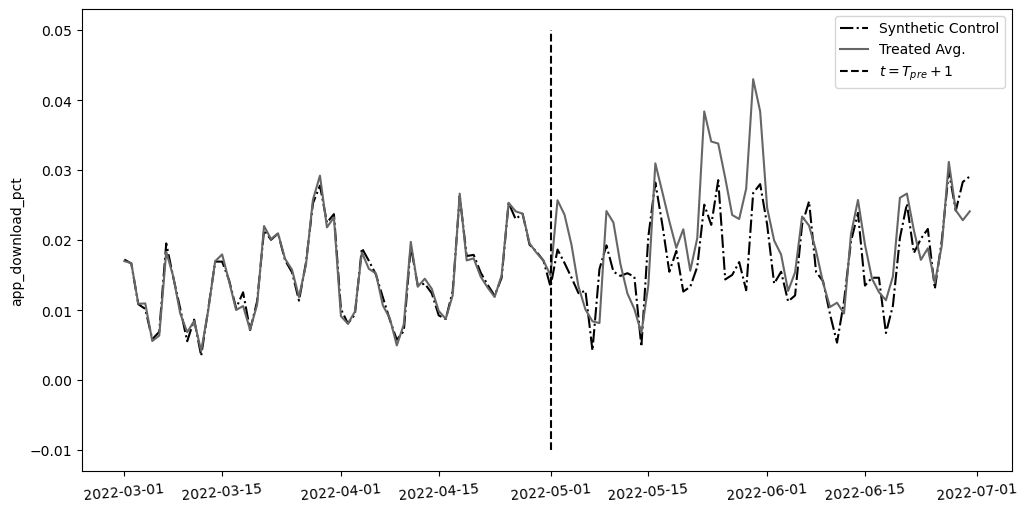

In [40]:
plt.figure(figsize=(12,6))

y_co = pd.concat([y_pre_co, y_post_co])     # control group, pre-/post-treatment
y_tr = pd.concat([y_pre_tr, y_post_tr])     # treated group, pre-/post-treatment

plt.plot(y_co.index, model.predict(y_co).mean(axis=1),  # synthetic control evolution over time
         label="Synthetic Control", ls="-.")        

plt.plot(y_tr.mean(axis=1), label="Treated Avg.")       # average treatment outcome evolution over time

plt.vlines(pd.to_datetime("2022-05-01"), -0.01, 0.05,   # beginning of post-treatment period
           ls="dashed", label="$t=T_{pre}+1$") 

plt.xticks(rotation=5)
plt.ylabel("app_download_pct")
plt.legend()

In [41]:
from sklearn.linear_model import LinearRegression 

model = LinearRegression(fit_intercept=False)   # we don't want intercept in this case, just pure weights
model.fit(y_pre_co, y_pre_tr.mean(axis=1))      # .mean() to fit to E[Y_0|D=1], average treatment outcome

# extract the weights
weights_lr = model.coef_ 
weights_lr.round(3)

array([-0.65 , -0.058, -0.239,  0.971,  0.03 , -0.204,  0.007,  0.095,
        0.102,  0.106,  0.074,  0.079,  0.032, -0.5  , -0.041, -0.154,
       -0.014,  0.132,  0.115,  0.094,  0.151, -0.058, -0.353,  0.049,
       -0.476, -0.11 ,  0.158, -0.002,  0.036, -0.129, -0.066,  0.024,
       -0.047,  0.089, -0.057,  0.429,  0.23 , -0.086,  0.098,  0.351,
       -0.128,  0.128, -0.205,  0.088,  0.147,  0.555,  0.229])

In [42]:
# predict the synthetic control (post-intervention outcome for treated units).
y0_tr_hat = y_post_co.dot(weights_lr)       # similar to y0_tr_hat = model.predict(y_post_co).mean(axis=1)

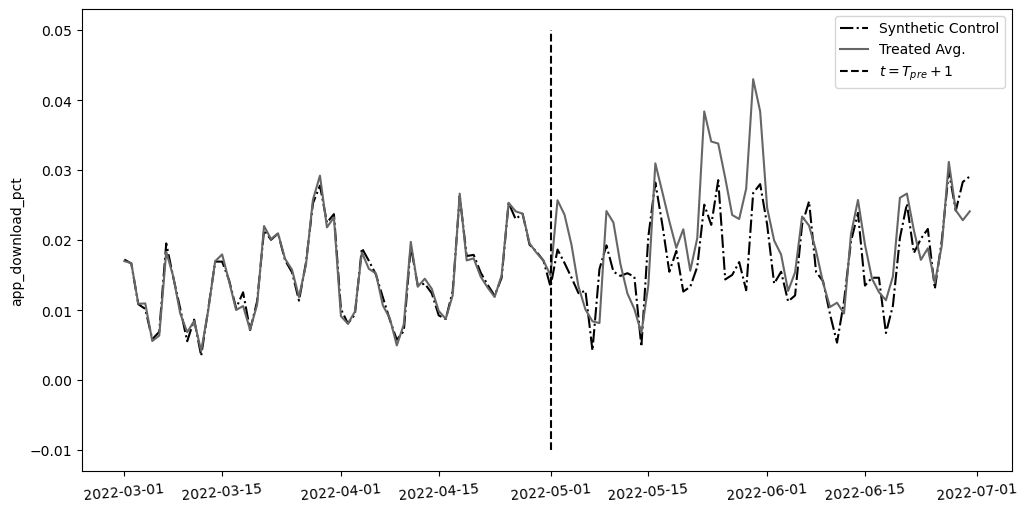

In [43]:
plt.figure(figsize=(12,6))

y_co = pd.concat([y_pre_co, y_post_co])     # control group, pre-/post-treatment
y_tr = pd.concat([y_pre_tr, y_post_tr])     # treated group, pre-/post-treatment

plt.plot(y_co.index, model.predict(y_co),               # predicts E[Y_0|D=1] directly over time
         label="Synthetic Control", ls="-.")            # synthetic control evolution over time

plt.plot(y_tr.mean(axis=1), label="Treated Avg.")       # average treatment outcome evolution over time

plt.vlines(pd.to_datetime("2022-05-01"), -0.01, 0.05,   # beginning of post-treatment period
           ls="dashed", label="$t=T_{pre}+1$") 

plt.xticks(rotation=5)
plt.ylabel("app_download_pct")
plt.legend()

In the post-intervention period, the predicted value (synthetic control) is below the actual outcome of the treated units. It means that the observed outcome was higher than you've estimated to be, had the treatment not taken place. This indicates a positive marketing effect from the online marketing campaign. You can compute the ATT estimate by contrasting the observed outcome with the synthetic control.

In [44]:
# ATT estimation
att = y_post_tr.mean(axis=1) - y0_tr_hat
att.mean()

0.0029460909509048797

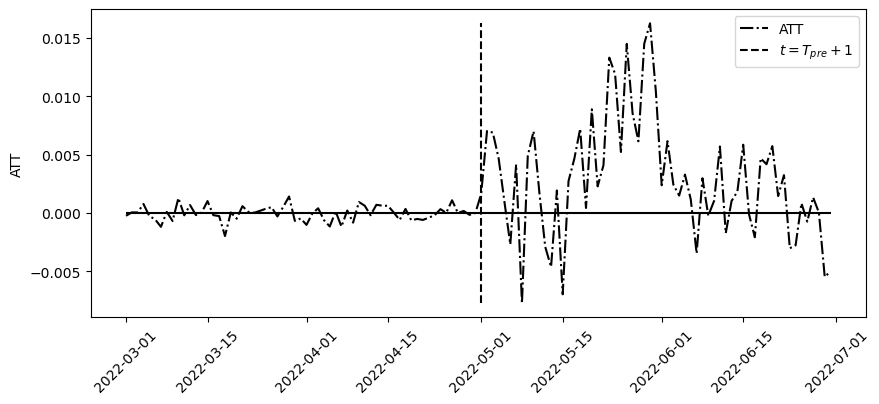

In [45]:
plt.figure(figsize=(10,4))
plt.plot(y_tr.mean(axis=1) - model.predict(y_co), label="ATT", ls="-.") # att using synthetic control
plt.vlines(pd.to_datetime("2022-05-01"), att.min(), att.max(), 
           ls="dashed", label="$t=T_{pre}+1$")                  # beginning of post-intervention period
plt.hlines(0, y_tr.index.min(), y_tr.index.max())               # treatment effect of 0 line
plt.ylabel("ATT")
plt.xticks(rotation=45)
plt.legend()

In the plot above, we obtain the treatment effect by subtracting the predicted potential outcome from the observed outcome for the treated group. In the post-intervention period, the effect takes some time to reach its peak before gradually declining. The gradual increase is frequently observed in marketing, since it usually requires time for individuals to take action after seeing an advertisement. Additionally, the effect wearing off can often be attributed to a novelty effect that gradually fades over time.

The second thing is the size of the treatment effect in the pre-intervention period. In that time frame, the treatment effect can be interpreted simply as the residual (in-sample error) from the OLS model. You might think that it being close to zero is a good thing, after all you don't want to see an effect prior to the treatment (anticipation). But the fact that the pre-intervention error is incredibly low can also mean that the OLS model is probably overfitting. As a result, the out-of-sample prediction, which should estimate $E[Y_0|D=1,Post=1]$, might be off. For this reason, simple regression is not commonly used as a method to build synthetic controls. The relatively large number of columns (control cities), tend to overfit, not generalizing to the post-intervention period. Because of this, the original synthetic control method is not a simple regression, but one that imposes reasonable and intuitive constraints.

#### Canonical Synthetic Control

Canonical synthetic control formulation imposes two constraints on the regression model:

1. Weights are all positive
2. Weights add up to one

The optimization objective becomes:

$\omega^{sc}=argmin_{\omega}||\bar y_{pre,tr} - Y_{pre,co}\omega_{co}||^2$

s.t $\Sigma \omega_i = 1$ and $\omega_i > 0$ ∀ $i$

The constraints force the synthetic control to be a convex combination of the treated units, avoiding extrapolation. Thus if the treated unit has an outcome greater (or lower) than all the control units, this canonical formulation won't be able to craft a synthetic control to recover $E[Y_0|D=1]$. This is meant as a guardrail, because the treatment units you are trying to reconstruct is very different from the ones in the control group and therefore you shouldn't even try.

Once you realize that synthetic control is just horizontal regression, you can find other ways to regularize it. For instance, you can use lasso or ridge regression. Still, it makes a lot of sense to not allow negative weights, especially if the units are geographies, as outcome tends to be positively correlated among those.

Like difference-in-differences, synthetic control assumes no anticipation of the treatment and no spillovers when using synthetic control. The main difference between the two methods is the parametric assumption about the potential outcome model. In diff-in-diff, you had to assume that the trend in $Y_0$ for treated units was parallel to $Y_0$ trend from the control units. Synthetic control on the other hand uses a vector autoregressive model or a linear factor model.

In [173]:
from sklearn.base import BaseEstimator, RegressorMixin 
from sklearn.utils.validation import (check_X_y, check_array, check_is_fitted)
import cvxpy as cp                      # convex optimization


class SyntheticControl(BaseEstimator, RegressorMixin):      # our estimator is a regressor

    def __init__(self):                                     # initialize regression estimator
        pass 

    def fit(self, y_pre_co, y_pre_tr):
        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr) # check X,y for consistent length; X is 2D and y 1D.

        w = cp.Variable(y_pre_co.shape[1])      # weights (optimization variables) length is number of features
        objective = cp.Minimize(cp.sum_squares(y_pre_co@w - y_pre_tr)) # cost function
        constraints = [cp.sum(w) ==1, w >= 0]   # canonical synthetic controls constraints

        problem = cp.Problem(objective, constraints)        # convex optimization problem

        # fitted values have a trailing underscore
        self.loss_ = problem.solve(verbose=False)           # add fitted attribute, final loss of estimator
        self.w_ = w.value                                   # add fitted attribute, weights values

        self.is_fitted_ = True                              # add is_fitted_ attribute for fit check below
        return self                                         # return fitted estimator
    
    def predict(self, y_co):
        check_is_fitted(self)       # verify presence of fitted attributes (ending with a trailing underscore)
        y_co = check_array(y_co)    # Input validation on an array      
        return y_co @ self.w_       # predict using weights

In [48]:
model = SyntheticControl()
model.fit(y_pre_co, y_pre_tr.mean(axis=1)) # use pre-treatment control to predict average pre-treatment treated

# extract the weights
model.w_.round(3)

array([-0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.076,  0.037,
        0.083,  0.01 , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        0.061,  0.123,  0.008,  0.074, -0.   ,  0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   , -0.   ,  0.092,
       -0.   , -0.   ,  0.   ,  0.046,  0.089,  0.   ,  0.067,  0.061,
        0.   , -0.   , -0.   ,  0.088,  0.   ,  0.086, -0.   ])

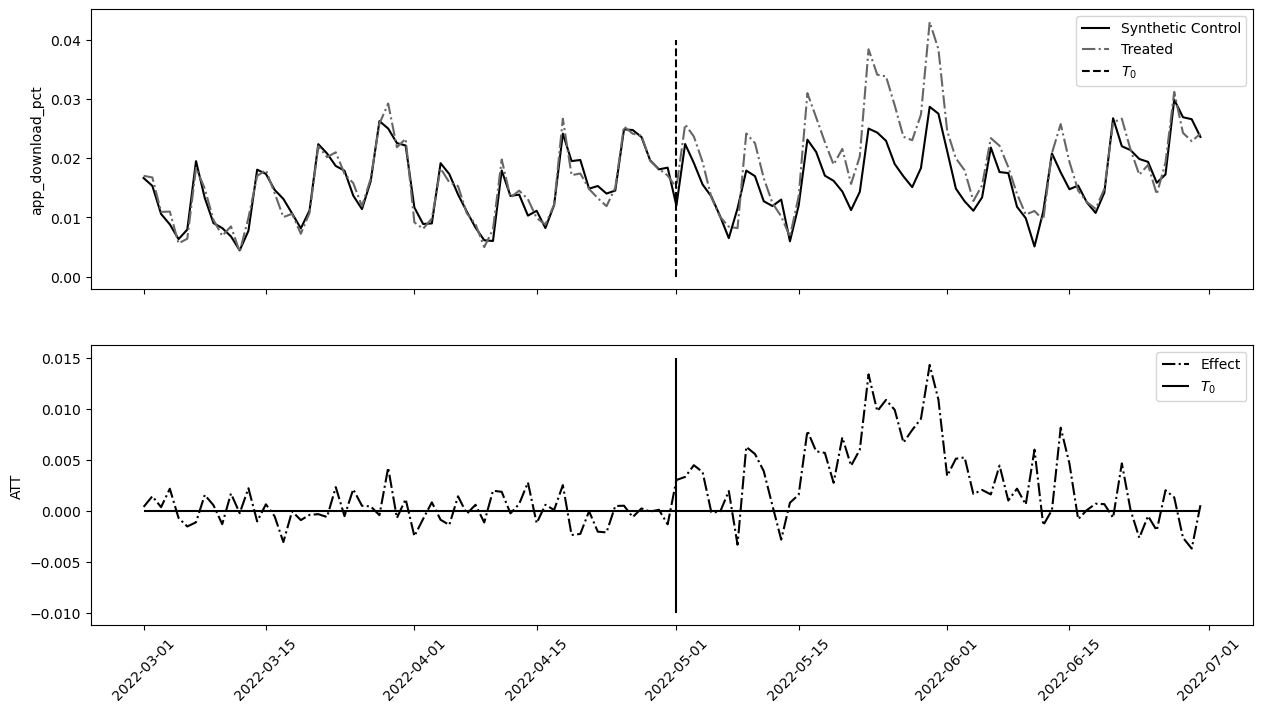

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True)

ax1.plot(y_co.index, model.predict(y_co), label="Synthetic Control")    # predict average treated from control
ax1.plot(y_tr.mean(axis=1), label="Treated", ls="-.")                   # plot average treated outcome Series
ax1.vlines(pd.to_datetime("2022-05-01"), 0, 0.04, ls="dashed", label="$T_0$") # post-intervention period start
ax1.legend()
ax1.set_ylabel("app_download_pct")


ax2.plot(y_co.index, y_tr.mean(axis=1) - model.predict(y_co),   # att using synthetic control
         label="Effect", ls="-.") 
ax2.hlines(0, y_co.index.min(), y_co.index.max())
ax2.vlines(pd.to_datetime("2022-05-01"), -0.01, 0.015, label="$T_0$")
ax2.legend()
ax2.set_ylabel("ATT")

plt.xticks(rotation=45);

#### Synthetic Control with Covariates

Usually, synthetic control uses just the pre-treatment outcome from the control units as features to predict $Y_{tr}$ since these tend to be the most predictive features. Sometimes, you may wish to include additional covariates, because you believe they have good predictive power. For our online marketing dataset, suppose you received data on the daily number of downloads from your main competitor in each city, normalized by market size, comp_download_pct and you think this covariate is a good predictor of $\bar Y_{tr}$, so you want to include it in the synthetic control model. In mathematical terms, you want to construct a synthetic control such that the weight $w_i$ is not only multiplied by $y_{co}$, but also by this extra covariate, $x_{co}$, in order to approximate $\bar Y_{tr}$. The issue is that $x_{co}$ and $y_{co}$ may be in completely different scales and one can be more predictive than the other. To address this, you need to multiply each covariate, including $y_{co}$ by a scaling factor $v$, before solving the SC optimization problem.

$\hat w^{sc}=argmin_{\omega}||\bar y_{pre,tr} - \Sigma v^*_{k} X_{k,pre,co }\omega _{co}||^2$ s.t $\Sigma \omega _i = 1\;and\; \omega _i > 0\; ∀\; i$

This objective doesnt tell you how to find the optimal, $v$. In order to do that, you'll have to wrap entire synthetic control into yet another optimization objective, which takes a pair of $vs$ and returns the loss and weights after fitting the synthetic control ie find_w_given_vs below. For example when you pass $v=[1,0]$ as the $vs$ and $[y_pre_co, x_pre_co]$ as the covariate list, you should get back the original synthetic control, since the extra covariate has zero weight. Then you wrap this function, find_w_given_vs,  in another function that takes an array of $vs$ and returns the optimization loss, ie v_loss() below. This new function can then be passed to scipy minimize() function, which will iteratively look for the best vs and return them to you. With the optimal $vs$, you can go back to find_w_given to obtain the synthetic control weights that take the covariates into account. With these weights, you can make predictions for $Y(0)$ and obtain the final ATT estimate that considers covariates.

In [50]:
df_norm_cov = (pd.read_csv("data/online_mkt_cov.csv").astype({"date": "datetime64[ns]"}))
df_norm_cov.head()

,app_download,population,city,state,date,post,treated,app_download_pct,comp_download_pct
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1,0.024733,0.026280
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1,0.021789,0.023925
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1,0.015545,0.018930
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1,0.011705,0.015858
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1,0.010067,0.014548


In [51]:
from toolz import partial  # partial gives new function with partial application of given arguments / keywords

reshaper = partial(reshape_sc_data,             # function for segmenting data
                   df=df_norm_cov,
                   geo_col="city",              # units column
                   time_col="date",             # time dimension column
                   tr_geos=treated,             # list of treated units
                   tr_start=str(tr_period)      # start of post-intervention period
                   )                            # partial function without y_col

y_pre_co, y_pre_tr, y_post_co, y_post_tr = reshaper(y_col = "app_download_pct") # Y by group and period
x_pre_co, _, x_post_co, _ = reshaper(y_col="comp_download_pct") # additional covariate by group and period

In [54]:
def find_w_given_vs(vs, x_co_list, y_tr_pre):
    X_times_v = sum([x*v for x, v in zip(x_co_list, vs)])   # combine the X's with vs and sum for new covariates
    model = SyntheticControl()                              # initialize convex optimization model
    model.fit(X_times_v, y_tr_pre)                          # fit convex optimization model to X*v and y

    return {"loss": model.loss_, "w": model.w_}

find_w_given_vs([1,0],
                [y_pre_co, x_pre_co],   # new X matrix
                y_pre_tr.mean(axis=1)   # y vector
                ).get("w").round(3)     # get() an element in a dict 

array([-0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.076,  0.037,
        0.083,  0.01 , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        0.061,  0.123,  0.008,  0.074, -0.   ,  0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   , -0.   ,  0.092,
       -0.   , -0.   ,  0.   ,  0.046,  0.089,  0.   ,  0.067,  0.061,
        0.   , -0.   , -0.   ,  0.088,  0.   ,  0.086, -0.   ])

In [60]:
from scipy.optimize import minimize 

def v_loss(vs):
    return find_w_given_vs(vs,                      # guess of v
                           [y_pre_co, x_pre_co],    # features, or covariates
                           y_pre_tr.mean(axis=1)    # outcome
                           ).get("loss")            # return the loss of model using current vs

v_solution = minimize(v_loss, [0,0], method="L-BFGS-B") # find vs that minimize loss returned by v_loss
v_solution.x    # optimal vs

array([1.88034589, 0.00269853])

In [61]:
# fitting with optimal vs
w_cov = find_w_given_vs(v_solution.x,
                     [y_pre_co, x_pre_co],
                     y_pre_tr.mean(axis=1)).get("w").round(3)
w_cov           # weights from SyntheticControl given optimal combination weights v.

array([-0.   , -0.   ,  0.   , -0.   , -0.   , -0.   ,  0.078,  0.001,
        0.033,  0.   , -0.   ,  0.034, -0.   , -0.   , -0.   ,  0.   ,
        0.016,  0.047,  0.03 ,  0.01 , -0.   , -0.   ,  0.   ,  0.055,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.046,
        0.078,  0.007,  0.   ,  0.   ,  0.138,  0.   ,  0.022,  0.008,
       -0.   ,  0.201,  0.   ,  0.035,  0.   ,  0.161, -0.   ])

In [68]:
# obtain Y(0) and final ATT estimate that considers covariates
y0_hat = sum([x*v for x,v in zip([y_post_co, x_post_co], v_solution.x)]).dot(w_cov) # combine covariates
att = y_post_tr.mean(axis=1) - y0_hat                           # treatment effect from potential outcomes
att.mean()  

0.0037483654791673772

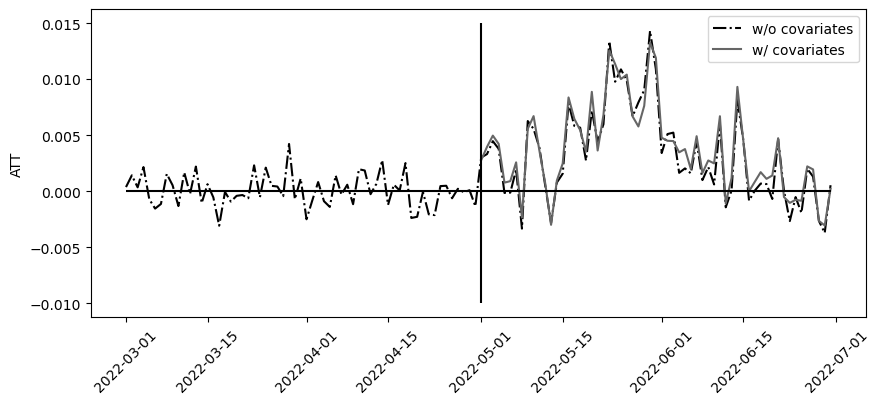

In [65]:
plt.figure(figsize=(10,4))
plt.plot(y_co.index, y_tr.mean(axis=1) - model.predict(y_co), 
         label="w/o covariates", ls="-.")                       # treatment effect without covariates
plt.plot(att.index, att, label="w/ covariates")                 # treatment effect with covariates

plt.hlines(0, y_co.index.min(), y_co.index.max())               # treatement effect of zero
plt.vlines(pd.to_datetime("2022-05-01"), -0.01, 0.015)          # start of post-intervention period
plt.legend()
plt.ylabel("ATT")
plt.xticks(rotation=45);

#### Generic Horizontal Regression

A simpler way to add covariates is to just concatenate any additional time series you deem worthy as a column to $Y_{pre_co}$. This would be equivalent to adding additional covariates in the horizontal regression.

$[Y_{pre,co}|X_{pre,co}]\omega$

This wouldn't be synthetic control in the strict sense of the words, since you are now estimating $E[Y(0)_{tr}]$ with the control units and those extra time series. You'll end up with weights, not only for the units, but for each additional column that you've concatenated.

#### Debiasing Synthetic Control

Prediction techniques are prone to overfitting, especially when the number of pre-treatment periods, $T_{pre}$, is small. Constraints imposed on the canonical synthetic control doesn't solve that completely. Thus Synthetic Control is known to be biased. Defining the ATT as the average across time in the post-intervention periods:

$ATT=\frac{1}{T1} \Sigma ^T _ {t=T0+1}(\bar Y_{1t} - \bar Y_{0t})$

T0 and T1 are the size of the pre- and post-intervention periods, $\bar Y _ {dt}$ is the average potential outcome of the treated units. This simply averages the ATT for each individual post-intervention period into a single number, making it easier to work with it. To check for bias in Synthetic Control method, you can compare that single number against its estimate.

The answer for debiasing synthetic control lies in cross-fitting. The idea is to partition pre-intervention period into K blocks, each of size min{$T_{pre}/K, T_{post}$}. Then, you'll treat each bolck as a hold-out set and fit a synthetic control model on $Y_{pre,co}^{-k}$ and $Y_{pre,tr}^{-k}$, where $-k$ means you'll drop the block from training. This step will give you weights $\hat \omega ^{-k}$. Next, you'll use those weights to make out-of-sample predictions using held-out data, $Y_{pre,co}^k$. The average difference between the predictions and observed values in hold-out data is an estimate for the bias, which you can use to adjust the ATT estimate. This will give K different ATTs which you can average out to get a final ATT estimate.

$\widehat {Bias}^k=avg(Y_{pre,tr}^k - Y_{pre,co}^k \hat \omega ^{-k})$

$\widehat {ATT}^k = Y_{post,tr} - Y_{post, co} \hat \omega ^{-k} - \widehat {Bias}^k$

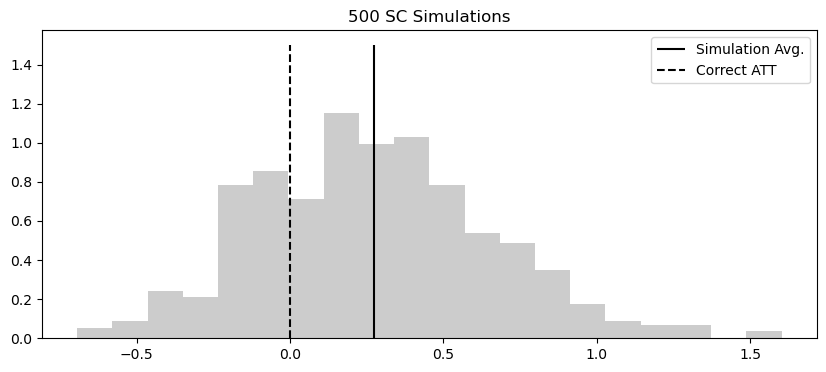

In [88]:
from statsmodels.tsa.arima_process import ArmaProcess 

# Panel data is time series so using ArmaProcess to generate time series data
def sim_sc_data(N=26, T0=15, T1=20):
    # generate control and treated pre-intervention T0 and post intervention T1 data
    Y_co = np.random.normal(
        np.array([np.concatenate([np.ones(3), np.zeros(N-3)])*2 for _ in range(T0+T1)])
    )                                                       # generate random control

    w = np.concatenate([np.ones(3), np.zeros(N-3)])*1/3     # weights
    Y_tr = Y_co.dot(w) + ArmaProcess(0.8).generate_sample(T0+T1) # treated is control plus random time series
    model = SyntheticControl().fit(
        y_pre_co=Y_co[:T0],
        y_pre_tr=Y_tr[:T0].flatten()  # fit on the first T0 data points, pre-intervention
    ) 
    return (Y_tr[T0:].flatten() - model.predict(Y_co[T0:])).mean() # att using potential outcome from SC

np.random.seed(123)

atts = [sim_sc_data() for _ in range(500)] 
plt.figure(figsize=(10,4))
plt.hist(atts, alpha=0.2, density=True, bins=20)
plt.vlines(np.mean(atts), 0, 1.5, label="Simulation Avg.")  # average att from 500 att sample
plt.vlines(0, 0, 1.5, label="Correct ATT", ls="dashed")
plt.title("500 SC Simulations")
plt.legend()

Note that k here refers to the number of hold out test sets. So suppose that you have five pre-intervention periods and three post-intervention periods and want to build K=2 blocks. The block size is 2.5, which is not a integer, so we floor it to two. This means we'll take two blocks of size two out of the pre-intervention period, in turn, as hold-out test sets. 2x2 gives four time periods, but you have five. By choosing to take the blocks from the end, of the pre-intervention period (makes more sense that way since to use the latest data over the oldest data), the first time period will never be removed. Then for each of the two blocks, you'll take it out of the training set (ie test set) and estimate an SC model to obtain $\hat \omega ^{-k}$. With these weights, you'll move to the removed block and estimate the bias term. Finally, you'll use both weights and bias estimates to make an ATT estimate in the post-intervention period. To do this in Python, index into the end of the pre-intervention period, y_pre_tr.index[-K*block_size:] to get an index with exactly K blocks. Then you'll use np.split() to break these indexes into K blocks, which will return an array with K rows, each containing the index to remove in each iteration. Once you have those blocks, you can iterate over them, fitting an SC model, estimating the bias and the ATT in the post-intervention period.

In [104]:
# estimating bias
def debiased_sc_atts(y_pre_co, y_pre_tr, y_post_co, y_post_tr, K=3):
    block_size = int(min(np.floor(len(y_pre_tr)/K), # block size determined by min of pre- divided by K
                         len(y_post_tr)))  # or post; if post-intervention size is smaller use that
    blocks = np.split(y_pre_tr.index[-K*block_size:],K)  # split the last K*block_size timestamps into K blocks

    def fold_effect(hold_out): # the holdout is a series of index values split into K blocks
        model = SyntheticControl()  # convex optimization synthetic control
        model.fit(     # drop hold out pre-intervention timestamps from control and treated
            y_pre_co.drop(hold_out),
            y_pre_tr.drop(hold_out)
        )
        bias_hat = np.mean(y_pre_tr.loc[hold_out] -             # bias is average error on hold out test
                        model.predict(y_pre_co.loc[hold_out])) 
        y0_hat = model.predict(y_post_co)       # predict over the entire post intervention control  
        return (y_post_tr - y0_hat) - bias_hat  # debias each individual ATT estimate with bias
    
    return pd.DataFrame([fold_effect(block) for block in blocks]).T # K debiased ATTs for post-intervention 

In [105]:
deb_atts = debiased_sc_atts(y_pre_co,
                            y_pre_tr.mean(axis=1),      # synthetic control predicts average treated outcome
                            y_post_co,
                            y_post_tr.mean(axis=1),     # synthetic control predicts average treated outcome
                            K=3)                        # 3 hold-out sets, hence 3 debiased individual ATTs
deb_atts.head()                                         # index values here are post-intervention period dates

,0,1,2
date,,,
2022-05-01,0.003314,0.002475,0.003228
2022-05-02,0.003544,0.002844,0.003356
2022-05-03,0.004644,0.003698,0.004744
2022-05-04,0.004706,0.002866,0.003630
2022-05-05,0.000134,-0.000541,0.000243


To get a final ATT estimate for each post-intervention period, you can average out the columns , deb_atts.mean(axis=1), or if you want a single ATT for the entire period, just average everything: deb_atts.mean(axis=1).mean().

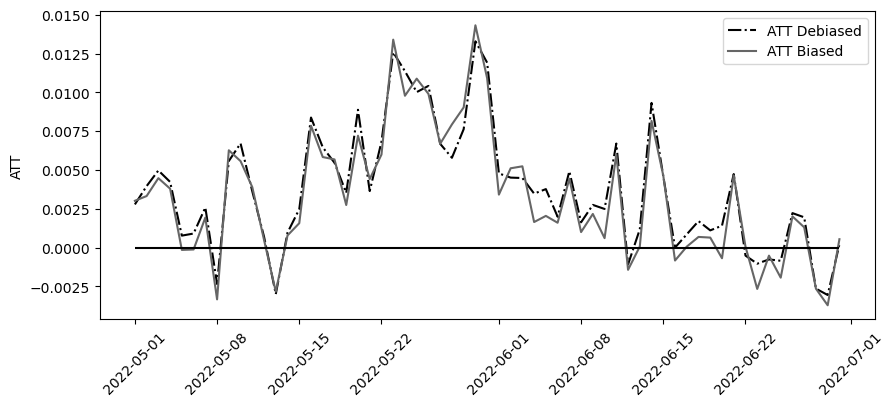

In [111]:
model_biased = SyntheticControl()
model_biased.fit(y_pre_co, y_pre_tr.mean(axis=1))   # synthetic control predicts the average treated outcome

att_biased = y_post_tr.mean(axis=1) - model_biased.predict(y_post_co) # estimate Y_0(D=1,Post=1) with y_post_co

plt.figure(figsize=(10,4))
plt.plot(att, label="ATT Debiased", ls="-.")        # why are we using the covariates att for debiased atts
plt.plot(att_biased, label="ATT Biased")
plt.legend()
plt.hlines(0, att.index.min(), att.index.max())
plt.ylabel("ATT")
plt.xticks(rotation=45);

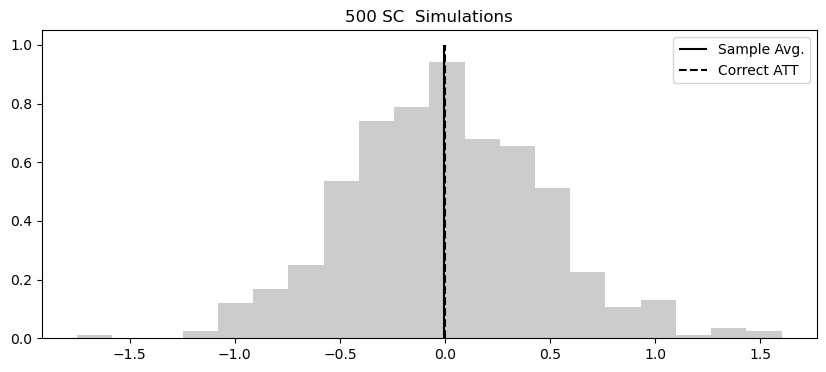

In [124]:
# Debiased att
def sim_deb_sc_data(N=16, T0=15, T1=28):
    Y_co = np.random.normal(
        np.array([np.concatenate([np.ones(3), np.zeros(N-3)])*2 for _ in range(T0+T1)])
    )

    w = np.concatenate([np.ones(3), np.zeros(N-3)])*1/3 
    Y_tr = Y_co.dot(w) + ArmaProcess(0.8).generate_sample(T0+T1)
    
    df_co = pd.DataFrame(Y_co)
    df_tr = pd.DataFrame(Y_tr)

    atts = debiased_sc_atts(df_co.iloc[:T0],
                            df_tr.iloc[:T0].mean(axis=1),  # synthetic control predicts average treated outcome
                            df_co.iloc[T0:],
                            df_tr.iloc[T0:].mean(axis=1), K=2)
    
    return atts.mean(axis=0).mean()
    
np.random.seed(123)

atts = [sim_deb_sc_data() for _ in range(500)]
plt.figure(figsize=(10,4))
plt.hist(atts, alpha=0.2, density=True, bins=20)
plt.vlines(np.mean(atts), 0, 1.0, label="Sample Avg.")
plt.vlines(0, 0, 1, label="Correct ATT", ls="dashed")
plt.title("500 SC  Simulations")
plt.legend()

#### Inference

The debiasing procedure places a confidence interval around the synthetic control ATT estimate. Doing inference with synthetic control has proven to be a daunting task, mostly because there are usually a few control units or even just one. Block bootstrap won't work here because a lot of the bootstrap samples will throw out all the treated units, making the ATT undefined. Inference for synthetic control methods rely on permuting the time dimension, as bootstrapping the units seems problematic. One such method, described below, is simple to implement and computationally efficient and it begins with debiasing the data. The debiased data will give one ATT estimate for each of the K folds and for each post-intervention time period (as columns and rows in a dataframe). First thing you need is the ATT itself, so you average out the rows of this data frame, which will give you a single ATT for each of the K folds, then you can take the average of that. For the inference part, the idea is to construct a standard error estimate based on each of the $ATT^k$:

$\hat \sigma = \sqrt{1 + \frac{BlockSize * K}{T_{post}}}*\sqrt{\frac{1}{K-1}\Sigma^K_{k=1}(ATT^k -ATT)}$

$\widehat {SE} = \hat \sigma / \sqrt K$

When coding this, you need to be careful to use the sample standard deviation, which means passing ddof=1 to np.std(), which will allow the use of (N-1) as the divisor (instead of the default N). With the standard error, you can construct a test statistic $\widehat {ATT}/\widehat {SE}$, which under the null hypothesis $HO:ATT=0$, has an asymptotic t-distribution with $K-1$ degrees of freedom. This means you can leverage it to construct a confidence interval using the t-distribution.

Higher values of K result at smaller confidence intervals at the cost of lowering the coverage of those intervals. For high Ks, the 1-⍺ CIs will contain the true ATT less than 1-⍺ of the time, especially when the number of pre-treatment periods is small. In this case, a reasonble choice of K is 3. When $T_0$ is very large, compared to N, you can try larger values of K to decrease the length of the confidence interval.


In [126]:
deb_atts.head()

,0,1,2
date,,,
2022-05-01,0.003314,0.002475,0.003228
2022-05-02,0.003544,0.002844,0.003356
2022-05-03,0.004644,0.003698,0.004744
2022-05-04,0.004706,0.002866,0.003630
2022-05-05,0.000134,-0.000541,0.000243


In [127]:
atts_k = deb_atts.mean(axis=0).values       # att per k-fold
att = np.mean(atts_k)                       # overall att value

print("atts_k: ", atts_k)
print("ATT: ", att)

atts_k:  [0.00414872 0.00260513 0.00318584]
ATT:  0.003313226501636449


In [129]:
K = len(atts_k)                             # number of folds
T0 = len(y_pre_co)                          # length of pre-intervention period
T1 = len(y_post_co)                         # length of post-intervention period
block_size = min(np.floor(T0/K), T1)        # block size in each K fold

se_hat = np.sqrt(1+((K*block_size)/T1))*np.std(atts_k, ddof=1)/np.sqrt(K)
print("SE: ", se_hat)

SE:  0.0006339596260850461


In [131]:
atts_k

array([0.00414872, 0.00260513, 0.00318584])

In [144]:
np.sqrt((sum((atts_k - att)**2))/(len(atts_k) - 1))

0.0007796406237882787

In [143]:
np.std(atts_k)          # using K as denominator

0.0006365739036754891

In [141]:
np.std(atts_k, ddof=1)    # using K-1 as denominator

0.0007796406237882787

In [132]:
# constructing a 90% CI (⍺=0.1)
from scipy.stats import t                   # t-distribution
alpha = 0.1                                 # false positive rate for 90# CI

[att - t.ppf(1-alpha/2, K-1)*se_hat,        # lower end
 att + t.ppf(1-alpha/2, K-1)*se_hat]        # upper end

[0.0014620735349405393, 0.005164379468332358]

#### Synthetic Difference-in-Differences

We can combine synthetic control and difference-in-differences into a single synthetic difference-in-differences (SDID) estimator. First, construct a synthetic control. Then use it as the control unit in a DID setting. The parallel assumption required for DID becomes much more plausible, since you are crafting a synthetic control for $E[Y(0)_{ti}|D=1]$. Also, because you are using DID, the synthetic control can focus on capturing just the trend of the treated unit, as it can have a different level of $Y(0)$.

In its canonical form, with one control block (never treated) and one treated block that gets treated all at the same time period, you could write DID with two-way fixed effects:

$\hat \tau ^{did} = argmin_{\mu,\alpha,\beta,\tau}${$\Sigma^N_{n=1}\Sigma^T_{t=1}(Y_{it}-\mu+\alpha _i + \beta_t + \tau W_{it})^2$}

where $\tau$ is the ATT, $\alpha _i$ are the unit-fixed effects, and $\beta _t$ are the time-fixed effects. The unit-effects capture the differences in intercepts for each unit while the time effects capture the general trend across both treated and control units. The main assumption behind DID is that the treated and untreated have the same $Y_0$ trend:

$\Delta Y(d)_i \;⊥\; D$

We can recast the synthetic control estimator into something that resembles the DID formulation. You can write the SC estimator as solving the following optimization problems:

$\hat \tau ^{sc} = argmin_{\beta, \tau}${$\Sigma_{n=1}^N \Sigma_{t=1}^T(Y_{it} -\beta _i - \tau W_{it})^2 \hat \omega _i ^{sc}$}

The weights for the control units $\hat \omega _i ^{sc}$ are obtained by optimizing the synthetic control objective. The preceding formulation of the SC objective is defined for all units, not just the control, so what are the treatment unit's weight?.  Since you care about the ATT, they are simply $N_{tr}/N$ (uniform weighting).

In [152]:
# Verify new formulation of SC is equivalent to old formulation
sc_model = SyntheticControl()   # convex optimization
sc_model.fit(y_pre_co, y_pre_tr.mean(axis=1))   # predict average treated outcome from control outcomes convex

(y_post_tr.mean(axis=1) - sc_model.predict(y_post_co)).mean() # synthetic control for Y_0(D=1); overall att

0.003327040979396121

In [153]:
# Add synthetic control weights to original marketing frame before matrix reshaping
unit_w = pd.DataFrame(zip(y_pre_co.columns, sc_model.w_),   # column names, cities (units) with model weights
                        columns=["city", "unit_weight"])    # make new dataframe with these column names 
unit_w.head()

,city,unit_weight
0,ananindeua,-0.000008
1,aparecida_de_goiania,-0.000001
2,aracaju,-0.000008
3,belem,-0.000012
4,belford_roxo,-0.000006


In [156]:
df_norm.head()

,app_download,population,city,state,date,post,treated,app_download_pct
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1,0.024733
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1,0.021789
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1,0.015545
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1,0.011705
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1,0.010067


In [154]:
# Merge unit weight data frame into original marketing data frame using city as key
df_with_w = (df_norm
             .assign(tr_post = lambda d: d["post"]*d["treated"])   # W combination of treated/post-intervention
             .merge(unit_w, on=["city"], how="left")  # add weights of control units from synthetic control
             .fillna({"unit_weight": df_norm["treated"].mean()}))   # treated units weight is N_tr/N, uniform
df_with_w.head() 

,app_download,population,city,state,date,post,treated,app_download_pct,tr_post,unit_weight
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1,0.024733,0,0.06
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1,0.021789,0,0.06
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1,0.015545,0,0.06
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1,0.011705,0,0.06
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1,0.010067,0,0.06


In [165]:
# Run weighted OLS with time-fixed effects using alternative synthetic control formulation

mod = smf.wls(
    "app_download_pct ~ tr_post + C(date)",  # model with W and time-fixed effects (alternative SC formulation)
    data = df_with_w.query("unit_weight>= 1e-10"),    # remove rows with very small weights to avoid errors
    weights = df_with_w.query("unit_weight>=1e-10")["unit_weight"]
)

mod.fit().params["tr_post"]   # tau is the coefficient of W in DID formulation of SC

0.0033293800074678578

Comparing the new SC formulation with TWFE formulation of DID, first it looks like SC has time-fixed effects, but not unit-fixed effects, while DID has both time- and unit-fixed effects, but no unit weights. This suggests a merger between the two models that include elements from both SC and DID:

$\hat \tau ^{sdid} = argmin _{\mu,\alpha,\beta,\tau}${$\Sigma^N_{n=1}\Sigma_{t=1}^{T}(Y_{it}-(\mu + \alpha_i + \beta_t + \tau D_{it})^2 \hat \omega _i)$}

The end goal is to estimate $E[Y_0|Post=1,Tr=1]$ and the purpose of the unit unit weights $\hat \omega _i$ is to use the control units to approximate the treated units. But there is also a time dimension which means you could use weights in pre-treatment periods to better approximate post-treatment period, giving the following SDID formulation, which includes $\hat \lambda _t$ as time weights:

$\hat \tau ^{sdid}=argmin_{\mu,\alpha,\beta,\tau}${$\Sigma^N_{n=1}\Sigma_{t=1}^{T}(Y_{it}-(\mu + \alpha_i + \beta_t + \tau D_{it})^2 \hat \omega _i \hat \lambda _t ^ )$}

#### Estimating Time Weights

In order to get the unit weights, we regressed the average outcome of the treated units on the outcome of the control units, both in in the pre-treatment period.

$\hat \omega _i ^{sc}=argmin_{\omega}||\bar y_{pre,tr} - Y_{pre,co}\omega_{co}||^2\;\;\;s.t\; \Sigma \omega_i=1\;and\; \omega_i > 0 \;∀\;i$

To get time weights, we just need to <b>transpose the $Y_{pre,co}$ and regress it on the average outcome of the control on the post-treatment period</b>:

$\hat \lambda _t ^ {sc} = argmin_{w}||\bar y _{pre,co} ^{'} - Y_{pre,co}^{'}\lambda _{pre}||^2\;\;\;s.t\; \Sigma \lambda_i=1\;and\; \lambda_i > 0 \;∀\;i$

If there was some kind of trend in the outcome, the average post-treatment period would have a higher or lower outcome than all the pre-treatment period you would extrapolate in order to get a good fit. Since SC doesn't allow for extrapolations, SDID formulation allows for an intercept shift $\lambda _0$ when finding the time weights (when building constraints you don't want to include the intercept):

$\hat \lambda _t ^ {sc} = argmin_{w}||\bar y _{pre,co} ^{'} - (Y_{pre,co}^{'}\lambda _{pre} + \lambda _0)||^2\;\;\;s.t\; \Sigma \lambda_i=1\;and\; \lambda_i > 0 \;∀\;i$



In [178]:
# Synthetic Control (with Intercept)
from sklearn.base import BaseEstimator, RegressorMixin 
from sklearn.utils.validation import (check_X_y, check_array, check_is_fitted)
import cvxpy as cp 


class SyntheticControl(BaseEstimator, RegressorMixin):      # our estimator is a regressor

    def __init__(self, fit_intercept=False):                # initialize regression estimator
        self.fit_intercept = fit_intercept

    def fit(self, y_pre_co, y_pre_tr):
        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)  # check X,y for consistent length; X is 2D and y 1D.

        intercept = np.ones((y_pre_co.shape[0],1))*self.fit_intercept   # intercept column is 1 if fit_intercept
        X = np.concatenate([intercept, y_pre_co], axis=1)   # add intercept column
        w = cp.Variable(X.shape[1])             # weights (optimization variables) length is number of features

        objective = cp.Minimize(cp.sum_squares(X@w - y_pre_tr)) # minimization function
        constraints = [cp.sum(w[1:]) ==1, w[1:] >= 0]           # intercept not included in constraints

        problem = cp.Problem(objective, constraints)        # convex optimization problem

        self.loss_ = problem.solve(verbose=False)           # add fitted attribute, final loss of estimator
        self.w_ = w.value[1:]                               # add fitted attribute, weights values

        self.is_fitted_ = True                              # add fitted attribute
        return self                                         # return fitted estimator
    
    def predict(self, y_co):
        check_is_fitted(self)       # verify presence of fitted attributes (ending with a trailing underscore)
        y_co = check_array(y_co)    # Input validation on an array      
        return y_co @ self.w_       # predict using weights

In [179]:
# Synthetic Control time weights
time_sc = SyntheticControl(fit_intercept=True)

time_sc.fit(
    y_pre_co.T,             # regress transpose of y_pre_co against unit average y_post_co 
    y_post_co.mean(axis=0)
)

time_w = pd.DataFrame(zip(y_pre_co.index, time_sc.w_), columns=["date", "time_weight"])
time_w.tail()

,date,time_weight
56,2022-04-26,-0.000011
57,2022-04-27,0.071965
58,2022-04-28,-0.000002
59,2022-04-29,0.078350
60,2022-04-30,0.000002


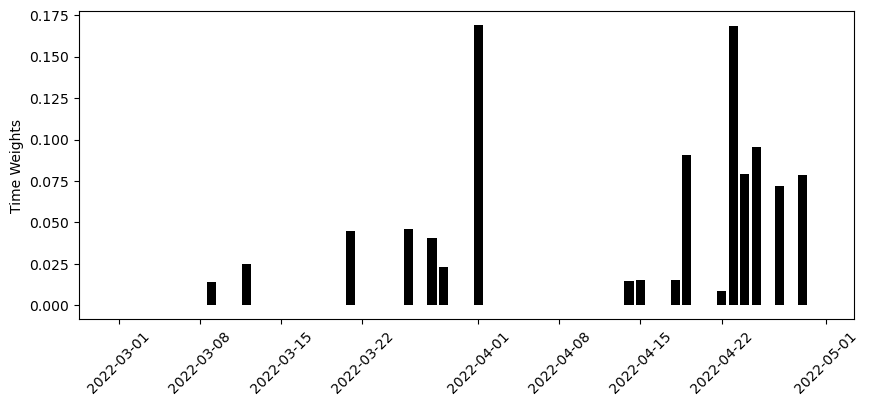

In [180]:
plt.figure(figsize=(10,4))
plt.bar(time_w["date"], time_w["time_weight"])
plt.ylabel("Time Weights")
plt.xticks(rotation=45);

#### Synthetic Control and DID

Now we have weights for the pre-intervention period and weights for all the units. We can start from df_with_w and join the time weights data frame, using date as the key. Since time_w has weights only for the pre-intervention period, you need to fill in the post-intervention time weights with $T_{post}/T$ (uniformly weighting). Finally, multiply both $\lambda _t$ and $\omega _i$. We can now run DID using the scid_df data and weighted regression. The parameter estimate associated with $W_{it} = D_i*Post_t$ is the ATT estimate you care about.

In [183]:
scdid_df = (
    df_with_w
    .merge(time_w, on=["date"], how="left")
    .fillna({"time_weight": df_norm["post"].mean()})
    .assign(weight = lambda d: (d["time_weight"]*d["unit_weight"])) # combine the weights
)

In [186]:
scdid_df.head()

,app_download,population,city,state,date,post,treated,app_download_pct,tr_post,unit_weight,time_weight,weight
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1,0.024733,0,0.06,-0.000006,-3.561818e-07
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1,0.021789,0,0.06,0.000011,6.420933e-07
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1,0.015545,0,0.06,-0.000004,-2.413431e-07
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1,0.011705,0,0.06,0.000002,9.378414e-08
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1,0.010067,0,0.06,0.000004,2.450524e-07


In [184]:
did_model = smf.wls(
    "app_download_pct ~ treated*post",
    data=scdid_df.query("weight>1e-10"),    # filter out small weights that can cause errors in regression
    weights=scdid_df.query("weight>1e-10")["weight"]).fit()
    
did_model.params["treated:post"]

0.0040861964041019275

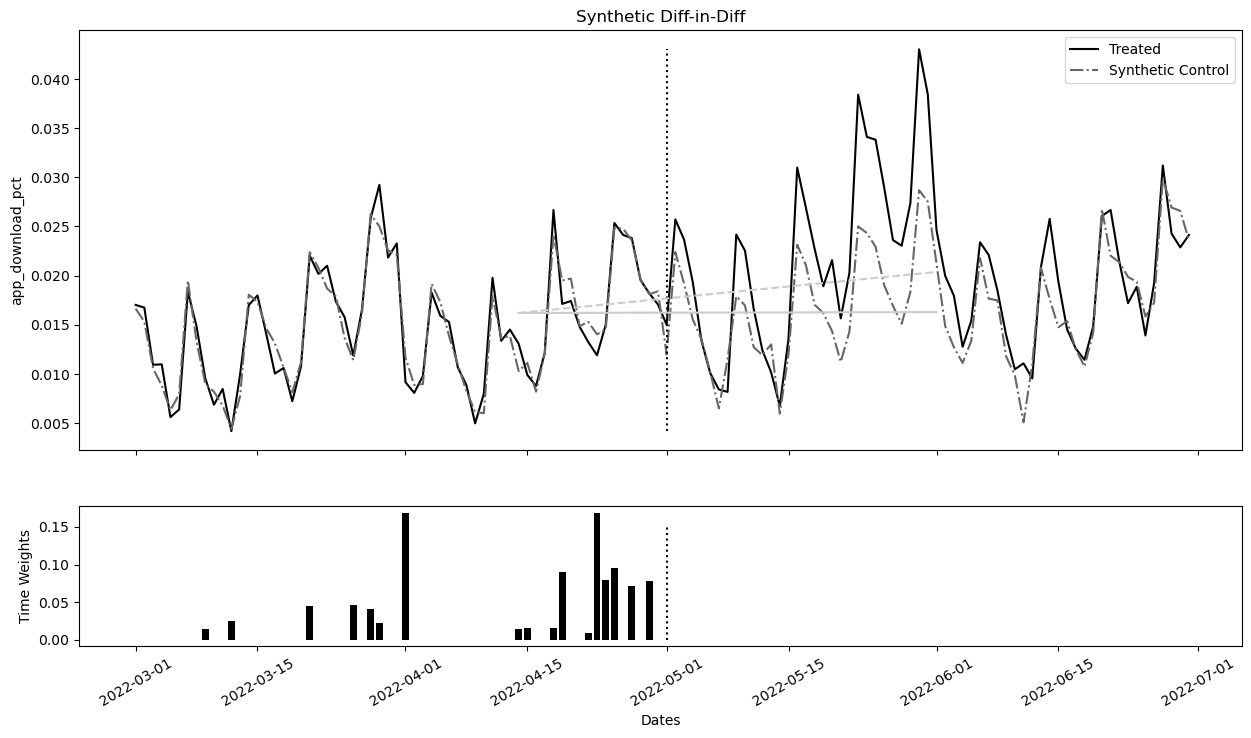

In [185]:
avg_pre_period = time_w.iloc[int((time_w["time_weight"]*np.arange(0,len(time_w),1)).sum().round())]["date"]
avg_post_period = pd.Timestamp("2022-06-01")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={"height_ratios": [3,1]})

ax1.plot(y_co.index, y_tr.mean(axis=1), label="Treated")       # average treated outcome
ax1.plot(y_co.index, sc_model.predict(y_co), label="Synthetic Control", ls="-.") # SC potential outcome
ax1.vlines(tr_period, y_tr.mean(axis=1).min(), y_tr.mean(axis=1).max(), color="black", ls="dotted")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["post"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["treated:post"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")
ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("app_download_pct")

ax2.bar(time_w["date"], time_w["time_weight"])
ax2.vlines(tr_period, 0, 0.15, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Dates")
plt.xticks(rotation=30);

SDID is interesting for a couple of reasons. The SC component of the estimator makes the DID's parallel trend assumption more plausible. It's much easier to get parallel trends if you first craft a synthetic control to mimic the treated units. SDID tends to have lower bias, compared to both DID and SC. Second, SDID also tends to have lower variance than both methods.